# Unsupervised Learning for Chemical Tomography: Synthetic XRD-CT Case Study

## 📝 Introduction


This tutorial demonstrates how unsupervised learning methods can be used to explore and analyse chemical tomography datasets, using synthetic data generated with the `nDTomo` package. The goal is to build a foundational understanding of how clustering and dimensionality reduction can help extract meaningful chemical and structural information from X-ray diffraction computed tomography (XRD-CT) datasets.

Rather than working with experimental data, we will use a fully synthetic **phantom XRD-CT dataset** with known ground truth components. This controlled setting allows us to benchmark the performance of different unsupervised methods and gain intuition about their strengths and limitations.

## 🧪 Background: What is Chemical Tomography?

Chemical tomography combines the principles of spatial imaging and spectral analysis. In techniques such as XRD-CT, each spatial voxel or pixel contains a **spectrum** — typically a diffraction pattern — rather than a single scalar intensity value. This results in a 3D data structure with dimensions $(x, y, \text{spectral})$.

In practice, chemical tomography data can be extremely rich but also very high-dimensional and noisy. Therefore, efficient data analysis methods are essential to:
- **Compress** the data (e.g. dimensionality reduction)
- **Identify key features** or patterns (e.g. clustering)
- **Extract chemical maps and reference spectra** without prior labelling

## 🧰 Methods We Will Use

In this notebook, we will explore three widely used unsupervised techniques. These methods are complementary and help answer different questions about the dataset.

### 📌 1. Principal Component Analysis (PCA)

PCA is a **linear dimensionality reduction** technique that transforms a dataset into a new coordinate system defined by directions of maximum variance.

Given a data matrix $X \in \mathbb{R}^{n \times p}$ (e.g., $n$ spectra each with $p$ features), PCA computes:

$$
X = T P^T
$$

- $T$: scores (the projection of the data in the reduced space)
- $P$: loadings (orthogonal vectors capturing directions of maximal variance)

This is equivalent to an eigen-decomposition of the covariance matrix:

$$
\text{Cov}(X) = P \Lambda P^T
$$

where $\Lambda$ is a diagonal matrix of eigenvalues.

PCA assumes linearity and that the directions of maximum variance are the most informative — which might not always be true for chemical mixtures, but it is a fast and useful first approximation.

### 📌 2. Non-negative Matrix Factorisation (NMF)

NMF is particularly suited to chemical data because it respects the non-negative nature of both:
- Spectral intensities
- Spatial concentrations

Given a non-negative data matrix $X \in \mathbb{R}_{+}^{n \times p}$, NMF seeks to approximate it as:

$$
X \approx W H
$$

- $W \in \mathbb{R}_{+}^{n \times k}$: spatial maps (concentrations)
- $H \in \mathbb{R}_{+}^{k \times p}$: spectral components (basis patterns)
- $k$: number of components (e.g. chemical phases)

The key assumption here is that the observed data are additive combinations of a few latent parts. This model aligns very well with how chemical species mix in diffraction or spectroscopic measurements.

NMF is more interpretable than PCA in many cases, especially when the underlying sources are sparse or physically distinct.

### 📌 3. K-Means Clustering

K-means is a widely used **partition-based clustering** method. It attempts to divide a dataset into $k$ clusters by minimising the **within-cluster sum of squares**:

$$
\min_{C} \sum_{i=1}^k \sum_{x \in C_i} \| x - \mu_i \|^2
$$

- $C_i$: the set of points in cluster $i$
- $\mu_i$: the centroid of cluster $i$

K-means makes no assumption about the underlying data distribution — it just finds groups of similar items. It can be applied:
- On spectra (to identify similar diffraction patterns)
- On images (to segment chemical domains)

One limitation is that $k$ must be chosen a priori, and it assumes that clusters are roughly spherical in feature space — which may or may not match the structure of real data.

## 🎯 Objectives

By the end of this tutorial, you will:
- Generate a synthetic XRD-CT phantom with 5 known components
- Apply PCA, NMF, and K-means to extract spatial and spectral features
- Compare algorithm outputs against known ground truth
- Understand the assumptions and trade-offs behind each method

Let’s begin by simulating the synthetic phantom dataset we will use for the rest of the analysis.

## 🧪 Generating a Synthetic XRD-CT Phantom with Known Ground Truth

To evaluate unsupervised learning methods, we need a dataset where the true spatial and spectral components are known. This allows us to quantitatively and visually compare the outputs of PCA, NMF, and K-means against a known reference.

`nDTomo` includes utilities to simulate realistic chemical tomography datasets with user-defined spectra and spatial distributions. We will simulate five chemical components, each defined by:
- A **2D spatial image** representing where the phase is located
- A **diffraction pattern** representing the spectral fingerprint of the phase

By linearly combining these, we generate a **3D volume** with shape $(x, y, q)$ where each pixel contains a synthetic diffraction pattern made of a weighted sum of the five reference patterns.


<KeysViewHDF5 ['Al', 'Cu', 'Fe', 'Pt', 'Zn', 'q', 'tth']>


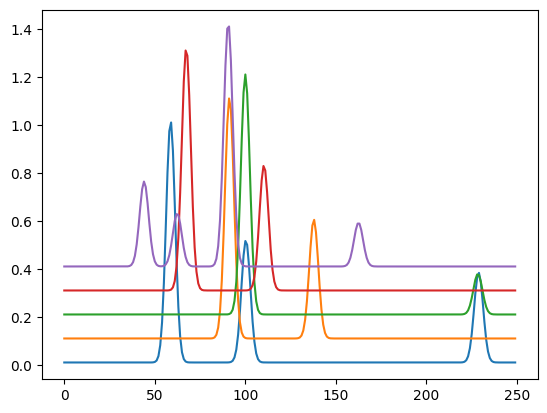

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nDTomo.sim.phantoms import load_example_patterns
from nDTomo.methods.plots import showspectra

# Load synthetic example patterns and associated axes
dpAl, dpCu, dpFe, dpPt, dpZn, tth, q = load_example_patterns()
spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]

# Display the diffraction patterns with vertical offsets
showspectra([dpAl, dpCu + 0.1, dpFe + 0.2, dpPt + 0.3, dpZn + 0.4])

We now create 2D spatial maps for the five chemical components. These serve as the mixing coefficients for each phase in the final volume.

In [2]:
from nDTomo.sim.phantoms import nDTomophantom_2D
from nDTomo.methods.plots import showim

# Image size
npix = 200

# Create 5 distinct phantom images (with non-overlapping shapes)
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]

/home/antonyvam/anaconda3/envs/ndtomo/lib/python3.8/site-packages/xdesign/geometry/area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


Each image is a $200 \times 200$ binary or continuous-valued map indicating the presence of a given chemical phase at each pixel. You can visualise them:

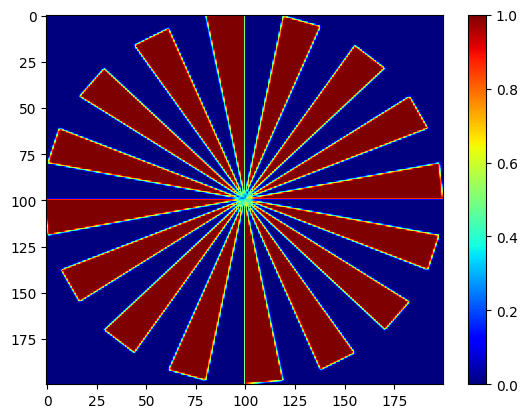

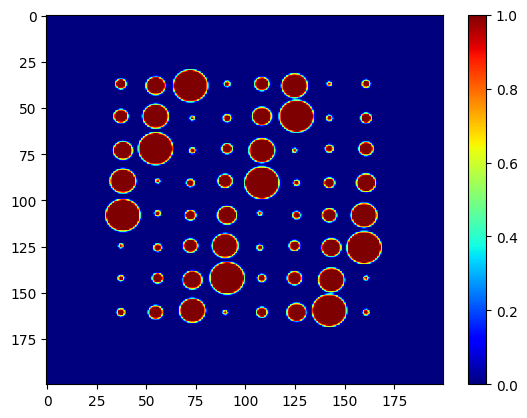

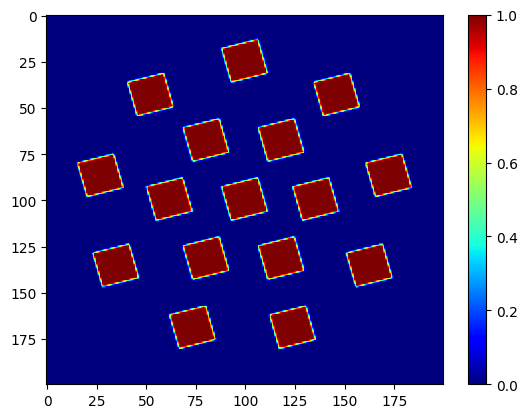

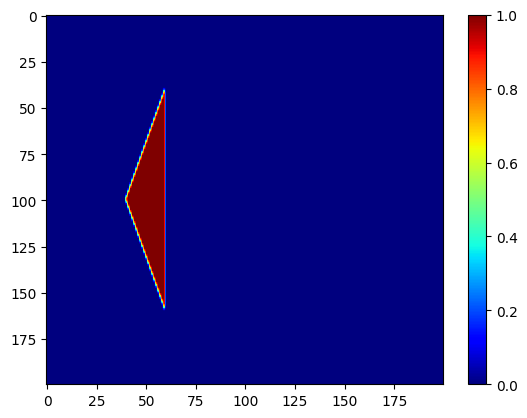

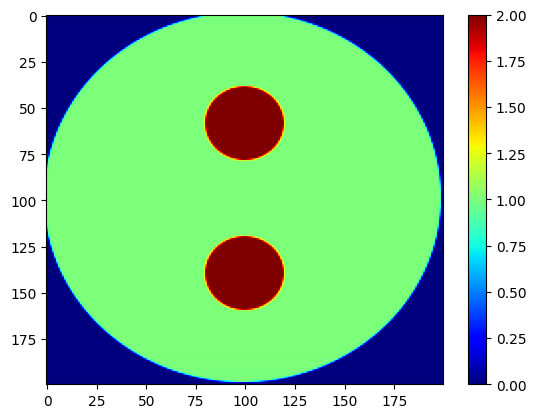

In [3]:
showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)

We now combine the spectra and images into a single 3D dataset using nDphantom_3D. The resulting volume has shape:
(x,y,q)=(200,200,250). This means we have 200×200 spatial pixels, and each pixel contains a synthetic diffraction pattern with 250 data points.

In [4]:
from nDTomo.sim.phantoms import nDTomophantom_3D

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print('Simulated chemical volume shape:', chemct.shape)

100%|██████████| 5/5 [00:01<00:00,  4.92it/s]

Simulated chemical volume shape: (200, 200, 250)


We can now interactively explore the spectral content of this volume using the HyperSliceExplorer


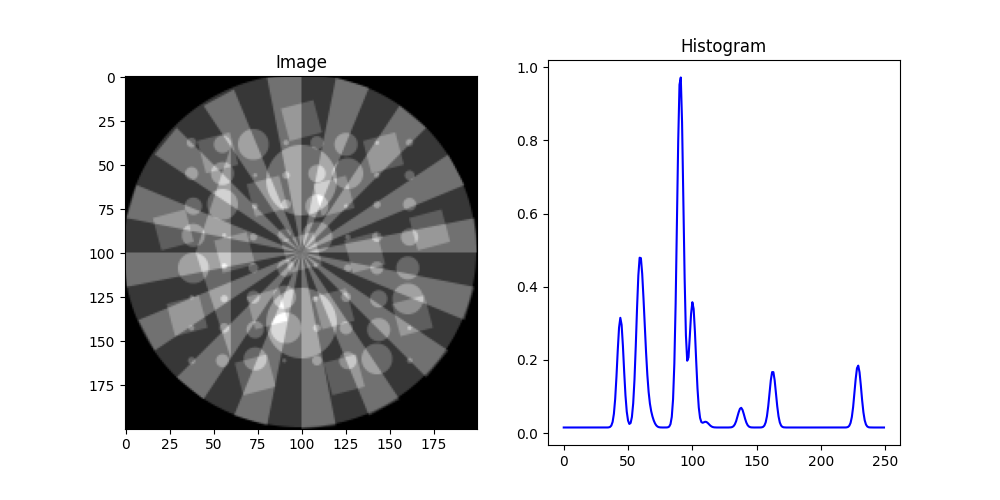

In [5]:


class chemimexplorer:
    
    def __init__(self, volume, fitted=None):
        """
        Initialize the chemimexplorer.

        Args:
            volume (ndarray): 3D array representing the volume data.
        """
        self.volume = volume
        self.fitted = fitted

        # Create main figure and subplots
        self.fig, (self.ax_image, self.ax_spectrum) = plt.subplots(1, 2, figsize=(10, 5))

        # Initialize with mean image and mean spectrum
        mean_image = np.mean(volume, axis=2)
        mean_spectrum = np.mean(volume, axis=(0, 1))
        if self.fitted is not None:
            mean_spectrum_fitted = np.mean(self.fitted, axis=(0, 1))

        # Plot the mean image and mean spectrum
        self.image = self.ax_image.imshow(mean_image.T, cmap='gray')
        if self.fitted is not None:
            self.spectrum, = self.ax_spectrum.plot(mean_spectrum, 'b+')
            self.spectrum_fitted, = self.ax_spectrum.plot(mean_spectrum_fitted, color='r')
        else:
            self.spectrum, = self.ax_spectrum.plot(mean_spectrum, color='b')

        # Set titles for image and spectrum
        self.ax_image.set_title('Image')
        self.ax_spectrum.set_title('Histogram')

        # Connect mouse hover events
        self.fig.canvas.mpl_connect('motion_notify_event', self.update_plots)
        self.fig.canvas.mpl_connect('button_press_event', self.toggle_real_time)

        # Initialize real-time update flags
        self.image_real_time_update = True
        self.spectrum_real_time_update = True

    def update_plots(self, event):
        """
        Update the image and spectrum plots based on the mouse hover event.

        Args:
            event (matplotlib.backend_bases.MouseEvent): Mouse hover event.
        """
        if event.inaxes == self.ax_image:
            if not self.image_real_time_update:
                return
            x, y = int(event.xdata), int(event.ydata)

            # Check if the mouse position is within the image dimensions
            image_width, image_height, _ = self.volume.shape
            if x >= 0 and x < image_width and y >= 0 and y < image_height:
                # Get the spectrum from the volume
                spectrum = self.volume[x, y, :]

                # Update the spectrum plot
                self.spectrum.set_ydata(spectrum)
                if self.fitted is not None:
                    spectrum_fitted = self.fitted[x, y, :]
                    self.spectrum_fitted.set_ydata(spectrum_fitted)

                self.ax_spectrum.relim()
                self.ax_spectrum.autoscale_view()

                # Set title with coordinates
                self.ax_spectrum.set_title(f'Histogram (x={x}, y={y})')

        elif event.inaxes == self.ax_spectrum:
            if not self.spectrum_real_time_update:
                return
            index = int(event.xdata)

            # Get the image from the volume
            image = self.volume[:, :, index]

            # Update the image display
            self.image.set_data(image.T)
            self.ax_image.relim()
            self.ax_image.autoscale_view()

            # Set title with bin
            self.ax_image.set_title(f'Image (Bin={index})')

            # Set color limits based on the current image
            self.image.set_clim(np.min(image), np.max(image))

        self.fig.canvas.draw()

    def toggle_real_time(self, event):
        """
        Toggle real-time update for image and spectrum plots on right-click.

        Args:
            event (matplotlib.backend_bases.MouseEvent): Mouse button press event.
        """
        if event.button == 3:
            if event.inaxes == self.ax_image:
                self.image_real_time_update = not self.image_real_time_update
            elif event.inaxes == self.ax_spectrum:
                self.spectrum_real_time_update = not self.spectrum_real_time_update
    
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)

## 🎯 K-Means Clustering in the Spectral Domain

Now that we have generated a synthetic chemical tomography volume, we begin our analysis using **K-Means clustering**.

The idea is simple: we treat each pixel’s diffraction pattern as a data point in a high-dimensional space (250-dimensional if there are 250 $q$-points), and we ask K-Means to group these patterns into $k$ clusters based on their similarity.

This approach assumes:
- There are $k$ distinct underlying chemical patterns (e.g., $k=5$)
- Each pixel contains a single dominant phase (no complex mixtures)

This is a useful first approximation and can reveal the gross chemical domains in the sample.


### 🔁 Reshape the Data

We begin by flattening the 3D volume from shape $(x, y, q)$ to a 2D array of shape $(n_{\text{pixels}}, q)$.



In [6]:
# Flatten the 3D volume to (num_pixels, spectral_dim)
data = chemct.reshape(-1, chemct.shape[2])
print("Data matrix shape:", data.shape)

Data matrix shape: (40000, 250)


We now apply the K-Means algorithm to cluster the diffraction patterns. We expect to recover 5 distinct clusters, corresponding to the 5 simulated components.

In [7]:
from sklearn.cluster import KMeans

# Number of expected clusters
k = 5

# Fit K-Means
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, random_state=0)
kmeans.fit(data)

# Get cluster labels and reshape to 2D image
labels = kmeans.labels_.reshape(chemct.shape[0], chemct.shape[1])

Each pixel is now assigned a cluster index from 0 to 4. We can visualise this as a labelled chemical map.

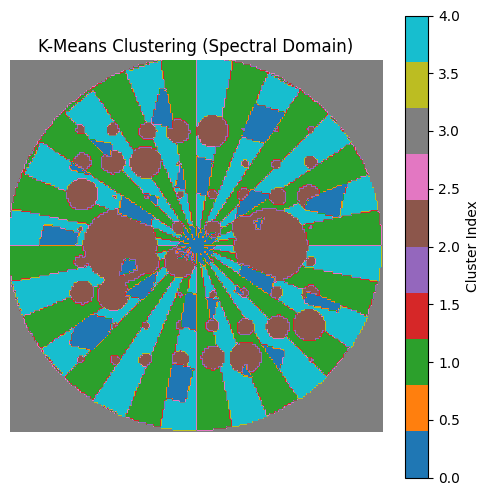

In [13]:
%matplotlib inline

plt.figure(figsize=(6,6))
plt.imshow(labels, cmap='tab10')
plt.title("K-Means Clustering (Spectral Domain)")
plt.axis('off')
plt.colorbar(label='Cluster Index')
plt.show()

To interpret the clusters, we compute the mean diffraction pattern for each one and compare it with the ground truth.

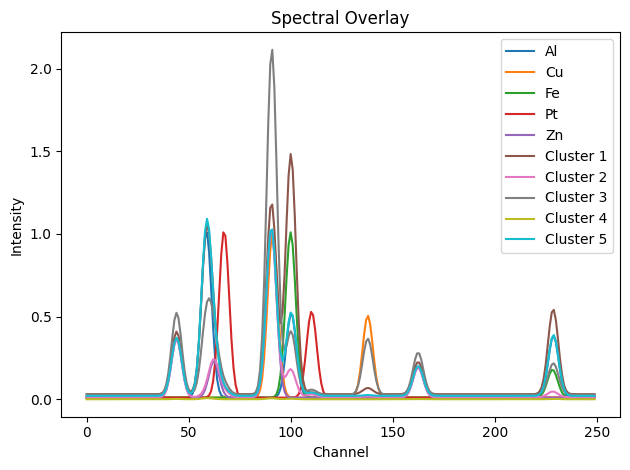

In [ ]:
cluster_spectra = []
for i in range(k):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_mean = data[cluster_indices].mean(axis=0)
    cluster_spectra.append(cluster_mean)
    
# Overlay with ground truth spectra
gt_spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]
all_spectra = gt_spectra + cluster_spectra
labels = ['Al', 'Cu', 'Fe', 'Pt', 'Zn'] + [f'Cluster {i+1}' for i in range(k)]
   
showspectra(all_spectra, labels=labels, fig_num=2)


## 🖼️ Visualise K-Means Cluster Maps Individually

To better understand the spatial structure captured by each K-Means cluster, we can visualise them one by one as grayscale maps.

Each map shows the **mean spectrum intensity** at each pixel that belongs to a given cluster. This is similar in spirit to the spatial maps extracted by NMF.


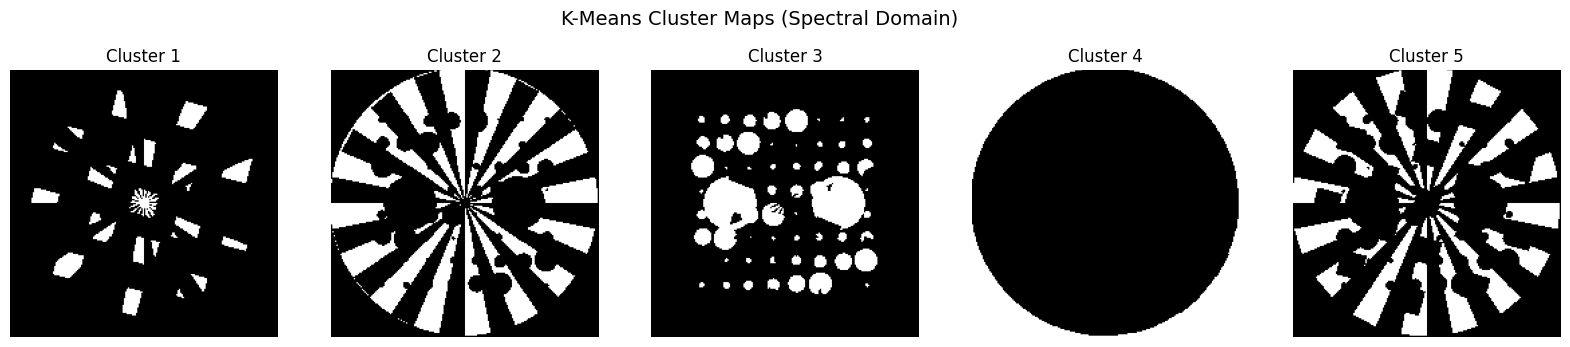

In [26]:
# Reshape chemct back to (x, y, spectral)
nx, ny, nq = chemct.shape
data = chemct.reshape(-1, nq)
labels_flat = kmeans.labels_

# Number of clusters
k = np.max(labels_flat) + 1

# Create a spatial map per cluster
cluster_maps = []
for i in range(k):
    mask = (labels_flat == i)
    map_i = mask.astype(float).reshape(nx, ny)
    cluster_maps.append(map_i)

# Plot the maps
fig, axs = plt.subplots(1, k, figsize=(20, 4))
for i in range(k):
    axs[i].imshow(cluster_maps[i], cmap='gray')
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].axis('off')
plt.suptitle("K-Means Cluster Maps (Spectral Domain)", fontsize=14)
plt.show()

Each map here is binary (0 or 1), indicating which pixels belong to each cluster. You can also modify this to show the mean intensity at each pixel within a cluster for better contrast or weight-based mapping:

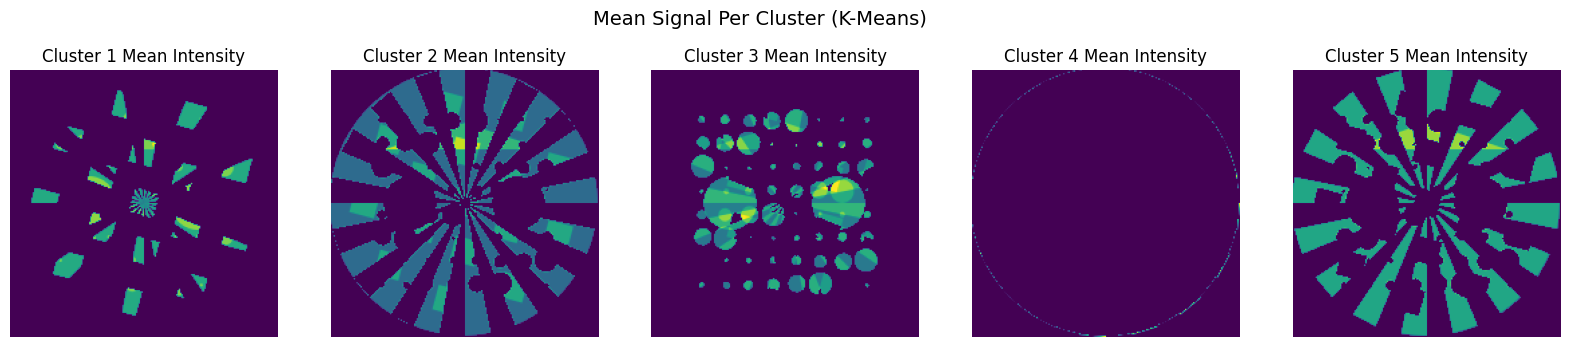

In [27]:
cluster_mean_maps = []
for i in range(k):
    mask = (labels_flat == i)
    masked_data = np.zeros((nx * ny,))
    masked_data[mask] = data[mask].mean(axis=1)
    cluster_mean_maps.append(masked_data.reshape(nx, ny))

# Plot intensity-based maps (alternative to binary masks)
fig, axs = plt.subplots(1, k, figsize=(20, 4))
for i in range(k):
    axs[i].imshow(cluster_mean_maps[i], cmap='viridis')
    axs[i].set_title(f"Cluster {i+1} Mean Intensity")
    axs[i].axis('off')
plt.suptitle("Mean Signal Per Cluster (K-Means)", fontsize=14)
plt.show()

## 📉 Principal Component Analysis (PCA) in the Spectral Domain

PCA is a widely used technique for **dimensionality reduction** and **exploratory data analysis**. It allows us to project high-dimensional data (e.g. diffraction patterns with 250 $q$-points) into a smaller number of orthogonal components that capture most of the variance in the dataset.

In the context of chemical tomography:
- Each spectrum is treated as a point in high-dimensional space
- PCA finds a new set of orthogonal axes (principal components)
- The first few components typically capture the main chemical differences
- The loadings of these components can be reshaped into images

PCA does not assume non-negativity or sparsity, and the resulting components may contain negative values. Nevertheless, PCA is fast and often reveals clear patterns.

### ⚙️ Perform PCA on the Spectral Data

We start by flattening the 3D dataset just as before, and apply PCA using `scikit-learn`.


In [18]:
from sklearn.decomposition import PCA

# Flatten the volume
data = chemct.reshape(-1, chemct.shape[2])

# Apply PCA
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(data)

# Get PCA scores (projections) and reshape into images
scores = pca.transform(data)
score_images = [scores[:, i].reshape(chemct.shape[0], chemct.shape[1]) for i in range(n_components)]

Each principal component reveals a direction of maximal variance. We can visualise the spatial distribution of each one.

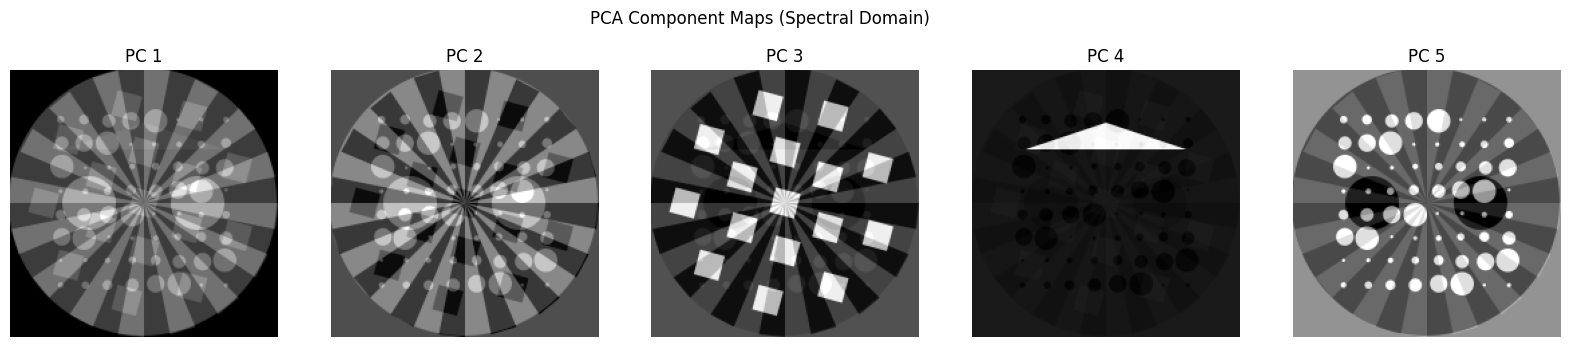

In [19]:
fig, axs = plt.subplots(1, n_components, figsize=(20, 4))
for i in range(n_components):
    axs[i].imshow(score_images[i], cmap='gray')
    axs[i].set_title(f'PC {i+1}')
    axs[i].axis('off')
plt.suptitle("PCA Component Maps (Spectral Domain)")
plt.show()

The PCA components (loadings) can be interpreted as basis patterns. Let’s plot them alongside the known diffraction patterns.

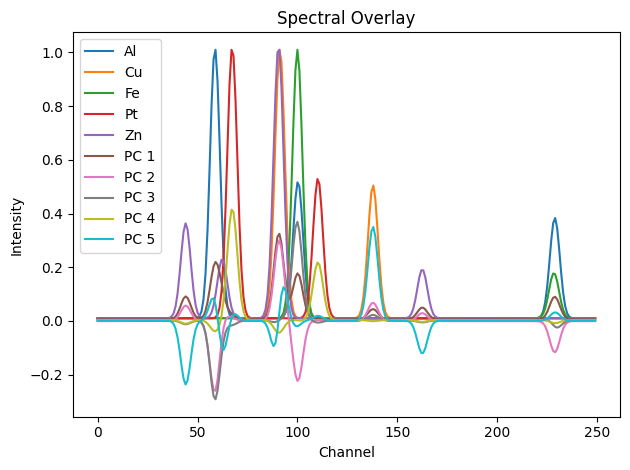

In [20]:
# Loadings are in shape (n_components, spectral_dim)
pca_patterns = pca.components_

# Combine with ground truth for comparison
gt_spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]
all_spectra = gt_spectra + list(pca_patterns)
labels = ['Al', 'Cu', 'Fe', 'Pt', 'Zn'] + [f'PC {i+1}' for i in range(n_components)]

showspectra(all_spectra, labels=labels, fig_num=3)

## 🟨 Non-negative Matrix Factorisation (NMF) in the Spectral Domain

Non-negative Matrix Factorisation (NMF) is a powerful technique for decomposing multivariate data into parts-based, interpretable components. Unlike PCA, which allows negative values, NMF constrains both the spatial maps and the spectral components to be non-negative. This aligns well with the physical nature of chemical imaging data, where:

- Spectral intensities are always $\geq 0$
- Concentrations or contributions of phases cannot be negative

This makes NMF particularly well-suited to applications such as hyperspectral imaging, chemometrics, and XRD-CT.

### 🧮 NMF Decomposition Model

Given a data matrix $X \in \mathbb{R}_{+}^{n \times p}$ (e.g., $n$ pixels, $p$ spectral points), NMF finds two non-negative matrices:

$$
X \approx W H
$$

- $W \in \mathbb{R}_{+}^{n \times k}$ contains the **spatial contributions** (each row is a pixel, each column is a component)
- $H \in \mathbb{R}_{+}^{k \times p}$ contains the **basis spectra** (each row is a spectral component)
- $k$ is the number of components (here, 5 to match the number of phases)

NMF is solved using an iterative algorithm that minimizes reconstruction error subject to non-negativity constraints.

### ⚙️ Apply NMF to the Flattened Dataset

We flatten the dataset and use `scikit-learn`’s NMF implementation:


In [22]:
from sklearn.decomposition import NMF

# Reshape volume to (num_pixels, spectral_dim)
data = chemct.reshape(-1, chemct.shape[2])
data[data < 0] = 0  # Ensure non-negativity for NMF

# Apply NMF
n_components = 5
nmf = NMF(n_components=n_components, init='nndsvd', max_iter=500, random_state=0)
W = nmf.fit_transform(data)
H = nmf.components_

The matrix W contains the spatial weights for each component at every pixel. We reshape each column back into an image.

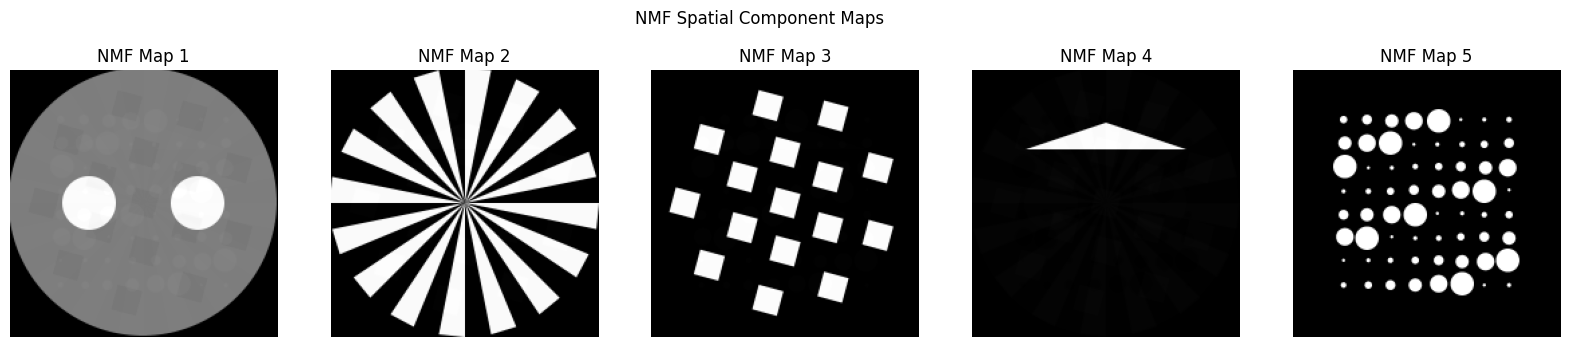

In [25]:
# Reshape spatial maps
nmf_maps = [W[:, i].reshape(chemct.shape[0], chemct.shape[1]) for i in range(n_components)]

fig, axs = plt.subplots(1, n_components, figsize=(20, 4))
for i in range(n_components):
    axs[i].imshow(nmf_maps[i], cmap='gray')
    axs[i].set_title(f'NMF Map {i+1}')
    axs[i].axis('off')
plt.suptitle("NMF Spatial Component Maps")
plt.show()

The matrix H contains the learned spectral components. We can compare these with the known diffraction patterns.

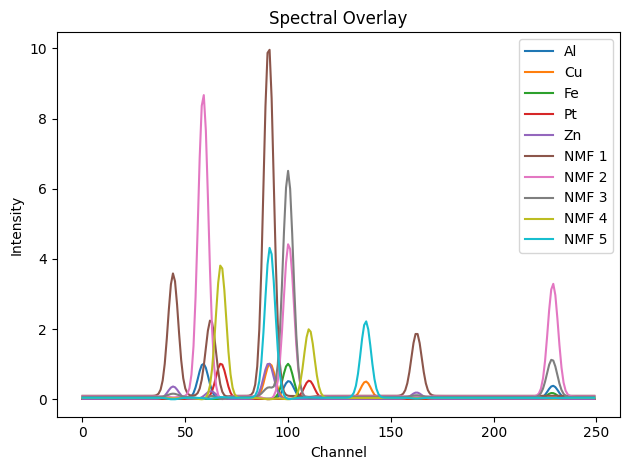

In [24]:
# Ground truth patterns
gt_spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]
all_spectra = gt_spectra + list(H)
labels = ['Al', 'Cu', 'Fe', 'Pt', 'Zn'] + [f'NMF {i+1}' for i in range(n_components)]

showspectra(all_spectra, labels=labels, fig_num=4)

## 🔍 Comparison and Discussion

We have now applied three foundational unsupervised learning methods — **K-Means**, **PCA**, and **NMF** — to a synthetic XRD-CT phantom dataset. Each method approaches the problem differently and has distinct strengths and weaknesses depending on how the data is represented.

### 📌 Summary of Observations

| Method   | Domain         | Output Type        | Strengths                                                                 | Limitations                                                             |
|----------|----------------|--------------------|--------------------------------------------------------------------------|-------------------------------------------------------------------------|
| K-Means  | Spectral       | Cluster Labels     | Simple and intuitive segmentation; fast                                   | Results are not impressive; hard clusters; can't handle mixtures well  |
| PCA      | Spectral/Image | Orthogonal Components | Fast; useful for variance exploration                                     | **Performs poorly** in both domains; results hard to interpret chemically |
| NMF      | Image          | Non-negative Maps and Spectra | Interpretable, accurate spatial maps; handles mixtures                   | Spectral output can still be inaccurate; sensitive to noise/init        |

### 🧭 Critical Evaluation of PCA and K-Means

A key takeaway from this tutorial is that **PCA performs poorly in both the spectral and image domains**. This is significant because PCA is one of the most commonly used methods in chemical imaging — often selected by default due to its simplicity and speed. However:

- The **principal components** extracted by PCA **do not align** well with the true underlying chemical patterns.
- The **spatial maps** derived from PCA often represent mixed or orthogonal directions of variance, which are **not chemically meaningful**.
- Despite its popularity, **PCA should not be used as a standalone unmixing method** in chemical tomography workflows.

Similarly, **K-Means applied in the spectral domain** struggles to resolve the true underlying components. The clustering boundaries do not correspond cleanly to phase distributions, especially in cases with spectral overlap or mixed pixels. Its performance is acceptable only when components are well separated and the signal-to-noise ratio is high.

### 🟨 Strength of NMF in the Image Domain

By contrast, **NMF performs remarkably well in the image domain**. The spatial maps closely resemble the ground truth, and the method effectively unmixed the synthetic chemical volume despite no prior knowledge of the component shapes or spectra.

However:
- The **spectral components recovered by NMF** are not as accurate as the spatial ones.
- In practice, combining NMF with good initialisation strategies or incorporating physical priors can help improve spectral accuracy.

### ✅ Practical Recommendations

- ❗ Avoid relying solely on PCA for chemical interpretation. It is useful for **variance analysis and noise filtering**, but not for identifying chemically meaningful components.
- 🌀 Use **K-Means** only for coarse segmentation or initial cluster estimation — not for unmixing or component extraction.
- 💡 Use **NMF in the image domain** when your goal is to extract both **chemical maps and approximate reference spectra**.
- 🔁 Consider combining methods: e.g., using PCA for denoising, K-Means for initialisation, and NMF for final unmixing.

### 🔄 Extending This Workflow

This synthetic phantom analysis provides a valuable benchmark. In real-world data, the situation becomes more complex due to noise, baseline drift, overlapping signals, and unknown mixtures. To handle such cases, you may consider:
- Adding **spatial or spectral constraints** to NMF
- Exploring **supervised or semi-supervised methods**
- Testing **advanced decompositions** like ICA, UMAP, or deep learning autoencoders

🎉 **End of Tutorial**

This notebook has walked through a complete unsupervised learning pipeline for XRD-CT data using known synthetic ground truth. It highlights not only how to apply these methods, but also **why their assumptions matter** — and where they can fail.

Understanding these tools' limitations is just as important as applying them.

Happy analysing!